In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

## Energy Balance

$$ 0 = -\frac{\Delta P}{\rho} + \frac{2 L}{D}f_f v^2 $$

$$ \implies{v = \sqrt{\frac{D \Delta P}{2 L \rho f_f}}} $$

## Reynold's Number 

$$\text{Re}  = \frac{\rho v D}{\mu} $$

## Colebrook Equation

Implicit expression, page 190. Most rigorous expression for friction factor. 

$$ \frac{1}{\sqrt{f_f}} = 4 \log_{10}\left(\frac{D}{e} \right) + 2.28 - 4 \log_{10}\left(4.67 \frac{D / e}{\text{Re} \sqrt{f_f}} + 1\right)$$

Can solve for $f_f$ by finding roots of the following function via Newton's method

$$ h(f_f) = \frac{-1}{\sqrt{f_f}} + 4 \log_{10}\left(\frac{D}{e} \right) + 2.28 - 4 \log_{10}\left(4.67 \frac{D / e}{\text{Re} \sqrt{f_f}} + 1\right) $$

Where the derivative is given by 

$$ h^\prime(f_f) = \frac{f_f^{-3/2}}{2}\left[1 + \left(\frac{1.737178}{4.67\frac{D / e}{\text{Re} \sqrt{f_f}} + 1}\right)\left(\frac{4.67 D / e}{\text{Re}}\right)\right]$$

And the iterative steps of Newton's method are expressed by 

$$ x_{n+1} = x_n - \frac{h(x_n)}{h^\prime(x_n)}$$

## Haaland's Equation 

Explicit expression, page 191. Useful approximation. 

$$ \frac{1}{\sqrt{f_f}} = -3.6 \log_{10}\left(\frac{6.9}{\text{Re}} + \left(\frac{e}{3.7 D}\right)^{10/9} \right) $$


## Solution Steps

1.) Assume value of $f_f$ in energy balance. Use this to calculate value of $v$

2.) Calculate the $\text{Re}$ based off of this $v$

3.) Put this calculated $\text{Re}$ into the Colebrook equation. Use Newton's method to solve for the roots to get $f_f$. Use Haaland's friction explicit factor expression as the initial guess. 

4.) If this $f_f$ is very different from initial guess, repeat procedure with answer from step 3 as new value in step 1. Iterate until convergence. 

In [2]:
def newton_raphson(f,fprime,guess):
    
    tol = 1e-8
    x1 = guess

    while True:
        x2 = x1 - f(x1)/fprime(x1)
        
        if abs((x2 - x1)/x1) <= tol:
            break
        
        x1 = x2
        
    return(x2)

In [3]:
def interpolate(x,x_data,y_data):
    # Interpolates the value of y from tabulated data given x
    
    bounds = 0
    last_point = 0
    
    for i in range(0,len(x_data)):
        if x_data[i] <= x:
            start = i
            bounds = 1
            if i == len(x_data) - 1:
                last_point = 1
            
        if x_data[i] > x and bounds == 1:
            end = i
            break
    
    if last_point != 1:
        x1 = x_data[start]
        y1 = y_data[start]
        x2 = x_data[end]
        y2 = y_data[end]
    
        y = (y2 - y1)/(x2 - x1)*(x - x1) + y1
    else:
        y = y_data[-1]
    
    return(y)

In [4]:
def water_physical_properties(T):
    
    # This function finds the physical properties of water at different temperatures
    # Interpolates from tabulated values in Appendix I of book
    
    # Tabulated data 
    T_data = [0,20,40,60,80,100] # Temperature [C]
    mu_data = [1794e-6,993e-6,538e-6,472e-6,352e-6,278e-6] # Dynamic viscosity [Pa s]
    Cp_data = [4226,4182,4175,4181,4194,4211] # Isobaric heat capacity [J / kg K]
    k_data = [0.558,0.597,0.633,0.658,0.673,0.682] # Thermal conductivity [W / m K]
    
    rho = 997 # density [kg / m^3]
    mu = interpolate(T,T_data,mu_data)
    Cp = interpolate(T,T_data,Cp_data)
    k = interpolate(T,T_data,k_data)
    
    return(rho,mu,Cp,k)

def wort_physical_properties(T):
    
    # This function finds the physical properties of wort at different temperatures
    # Approximate wort as 10% glucose solution 
    
    # Density - Engineering toolbox, Density of aqueous solutions of organic substances 
    rho = 1079.7 # [kg/m^3]
    
    # Viscosity - from paper by Telis, V.R.N et al 2007
    mu_T_data = [0,5,10,15,20,25,35,40,45,50,55,60,65,70,80,85,95]
    mu_data = [1.95,1.68,1.77,1.39,1.24,1.07,0.98,0.81,0.71,0.72,0.57,0.51,0.43,0.46,0.31,0.28,0.21] # mPa s 
    mu = interpolate(T,mu_T_data,mu_data)/1000 # Pa s
    
    # Heat capacity - from paper by Darros-Barbosa et al 2003
    # Heat capacity data for binary solutions fit to following model 
    a1 = 4.15263; b1 = -0.03271e-4; c1 = 1.994e-8
    a2 = -0.00107; b2 = 1.999e-8; c2 = -0.014e-12
    a3 = 0.174e-4; b3 = 0.013e-8; c3 = 0.0013e-13
    S = 0.1*rho # S is %w/v in g/mL --> S = weight percent * density
    term1 = (a1 + b1*S + c1*S**2)
    term2 = (a2 + b2*S + c2*S**2)*T
    term3 = (a3 + b3*S + c3*S**2)*T**2
    Cp = (term1 + term2 + term3)*1000 # [J / kg K]
    
    # Thermal conductivity - couldn't find good source, will approximate as water 
    k_T_data = [0,20,40,60,80,100] # Temperature [C]
    k_data = [0.558,0.597,0.633,0.658,0.673,0.682] # Thermal conductivity [W / m K]
    k = interpolate(T,k_T_data,k_data)
    
    return(rho,mu,Cp,k)

In [5]:
def pipe_friction(P,rho,mu,L,D,e,f_in):
    
    tol = 1e-8
    
    g = -9.81 # [m/s^2 acceleration due to gravity]
    
    f1 = f_in
    
    while True:
        
        v = np.sqrt(D*P/(2*L*rho*f1))
     
        Re = rho*v*D/mu
    
        def h(f): # Colebrook Equation 
        
            term1 = -1/f**0.5
            term2 = 4*np.log10(D/e) + 2.28
            term3 = -4*np.log10(4.67*(D/e)/(Re*f**0.5) + 1)
        
            return(term1 + term2 + term3)
    
        def hprime(f):
        
            term1 = 4.67*D/(Re*e)
            term2 = 1 + 1.737178/(term1/f**0.5 + 1)*term1
            term3 = f**-1.5/2*term2
        
            return(term3)
    
        # Haaland Equation 
        f_guess = (-3.6*np.log10(6.9/Re + (e/(3.7*D))**(10/9)))**-2
        
        # Newton's Method
        f2 = newton_raphson(h,hprime,f_guess)
        
        if (f2-f1)/f1 <= tol:
            v = np.sqrt(D*P/(2*L*rho*f2))
            Re = v*rho*D/mu
            break 
            
        f1 = f2
        
    return(v,Re,f2)

def pipe_head_loss(rho,mu,v,D,e,L):
    
    tol = 1e-8
    g = 9.81 # m/s^2
    
    Re = rho*v*D/mu
    
    def h(f): # Colebrook Equation 
        
        term1 = -1/f**0.5
        term2 = 4*np.log10(D/e) + 2.28
        term3 = -4*np.log10(4.67*(D/e)/(Re*f**0.5) + 1)
        
        return(term1 + term2 + term3)
    
    def hprime(f):
        
        term1 = 4.67*D/(Re*e)
        term2 = 1 + 1.737178/(term1/f**0.5 + 1)*term1
        term3 = f**-1.5/2*term2
        
        return(term3)
        
    # Haaland Equation 
    f_guess = (-3.6*np.log10(6.9/Re + (e/(3.7*D))**(10/9)))**-2
    
    # Newton's Method
    f = newton_raphson(h,hprime,f_guess)
    
    head_loss = 2*f*L/D*v**2/g
    
    return(head_loss,Re,f)
    

## For our heat exchanger 

In [6]:
def water_flow(rho,mu,L,P):

    # rho - density [kg / m^3]
    # mu - viscosity [Pa s]
    # L - length pipe [m]
    # P - Pressure drop [Pa]

    Di = 0.0127 # [m] Inner pipe outer diameter - (3/8 in size has 0.5 in OD)
    Do = 0.0254 # [m] Outer pipe inner diameter - (1 in size has 1 in ID)
    Ri = Di/2
    Ro = Do/2
    Acs = np.pi*(Ro**2 - Ri**2) # [m^2] Cross section area 
    Wetted_Perim = np.pi*(Di + Do) # [m] Wetted Perimeter
    DH = Acs/Wetted_Perim # [m] Hydraulic Diameter 
    D = 4*DH              # [m] Equivalent Diameter - 0.625 in when Ri = 3/8 in, Ro = 1 in
    eD = 0.00004 # [] e/D Relative roughness, Figure 13.2, p.193 (assumes drawn tubing)
    e = eD*D
    f_guess = 0.001

    v,Re,f = pipe_friction(P,rho,mu,L,D,e,f_guess)
    
    # v - average velocity [m/s]
    # Re - reynold's number []
    # f - friction factor []

    V = Acs*v # [m^3/s] volumetric flow rate
    m = V*rho # [kg / s] mass flow rate 

    return(m,v,Re,f)

def wort_flow(rho,mu,L,V):

    # rho - density [kg / m^3]
    # mu - viscosity [Pa s]
    # L - length pipe [m]
    # P - Pressure drop [Pa]
    
    g = 9.81 # [m/s^2]
    D = 0.0102108 # [m] Pipe inner diameter - 0.402 in 
    R = D/2 # [m] Pipe radius
    Acs = np.pi*R**2 # [m] Cross sectional area
    eD = 0.00004 # [] e/D Relative roughness, Figure 13.2, p.193 (assumes drawn tubing)
    e = eD*D
    f_guess = 0.001
    
    m = V*rho # [kg / s] mass flow rate 
    v = V/Acs # [m/s] Average velocity
    
    hL,Re,f = pipe_head_loss(rho,mu,v,D,e,L)
    
    # hL - head loss [m]
    # Re - reynold's number []
    # f - friction factor []
    
    W_pump = m*g*hL # [Watts] Power required
    
    return(m,v,Re,f,hL,W_pump)

In [7]:
def UA_overall(k,L,ri,ro,Ai,hi,Ao,ho):
    term1 = 1/(Ai*hi)
    term2 = np.log(ro/ri)/(2*np.pi*k*L)
    term3 = 1/(Ao*ho)
    UA = 1/(term1 + term2 + term3)
    
    return(UA)

def Effectiveness(UA,C_min,C_max):
    NTU = UA/C_min
    numerator = 1 - np.exp(-NTU*(1 - C_min/C_max))
    denominator = 1 - (C_min/C_max)*np.exp(-NTU*(1 - C_min/C_max))
    E = numerator/denominator
    return(E)
    
def Dittus_Boelter(Re,Pr,side):
    if side == 'h':
        n = 0.3 # Hot side --> fluid being cooled
    else:
        n = 0.4 # Cold side --> fluid being heated 
    Nu = 0.023*Re**0.8*Pr**n
    return(Nu)

In [545]:
def Heat_Exchanger(Tc_in,Th_in,P_c,V_h,L):
    """
    Tc_in - cold side inlet temp [C]
    Th_in - hot side inlet temp [C]
    P_c - cold side pressure drop [Pa]
    V_h - hot side volumetric flow [m^3/s]
    L - heat exchanger length [m]
    """
    
    # System Geometry 
    D_ii = 0.0102108 # [m] Inner Pipe ID - 0.402 in
    D_io = 0.0127 # [m] Inner Pipe OD - 0.5 in 
    D_oi = 0.0254 # [m] Outer pipe inner diameter - (1 in size has 1 in ID)
    R_ii = D_ii/2 
    R_io = D_io/2
    Ai = 2*np.pi*R_ii*L # [m^2] Inner surface area  
    Ao = 2*np.pi*R_io*L # [m^2] Outer surface area 
    k_pipe = 386 # [W/(m K)] thermal conductivity of copper 
    
    # Initially evaluate physical properties at inlet temperatures
    
    Tc_out = Tc_in
    Th_out = Th_in
    
    # Convergence criteria
    tol = 1e-10
    
    while True:
        
        # Arithmetic mean temperatures
        Tc_avg = (Tc_in + Tc_out)/2
        Th_avg = (Th_in + Th_out)/2
        
        Tc_out_old = Tc_out
        Th_out_old = Th_out

        # Get physical properties 
        rho_c,mu_c,Cp_c,k_c = water_physical_properties(Tc_avg)
        rho_h,mu_h,Cp_h,k_h = wort_physical_properties(Th_avg)
        
        # Determine flow properties within pipes
        m_c,v_c,Re_c,f_c = water_flow(rho_c,mu_c,L,P_c)
        m_h,v_h,Re_h,f_h,hL,W_pump = wort_flow(rho_h,mu_h,L,V_h)
        
        # Prandtl number 
        Pr_c = Cp_c*mu_c/k_c
        Pr_h = Cp_h*mu_h/k_h
        
        # Nusselt number 
        Nu_c = Dittus_Boelter(Re_c,Pr_c,'c')
        Nu_h = Dittus_Boelter(Re_c,Pr_c,'h')
        
        # Convective heat transfer coefficients
        D_eq = D_oi - D_io # [m] Equivalent diameter for annalus (water flow)
        ho = Nu_c*k_c/D_eq
        hi = Nu_h*k_h/D_ii
    
        # Overall heat transfer coefficient 
        UA = UA_overall(k_pipe,L,R_ii,R_io,Ai,hi,Ao,ho)
        U = UA/Ao
        
        # Use NTU method to estimate rate of heat transfer 
        C_c = m_c*Cp_c
        C_h = m_h*Cp_h
    
        if C_h < C_c:
            C_min = C_h
            C_max = C_c
        else:
            C_min = C_c
            C_max = C_h
        
        # Heat exchanger effectiveness
        E = Effectiveness(UA,C_min,C_max)
    
        # Heat transferred 
        q = E*C_min*(Th_in - Tc_in)
    
        # Outlet temperatures 
        Tc_out = q/C_c + Tc_in
        Th_out = Th_in - q/C_h
        
        change_c = np.abs(Tc_out - Tc_out_old)/Tc_out
        change_h = np.abs(Th_out - Th_out_old)/Th_out
        
        if change_c < tol and change_h < tol:
            break
            
    cold_properties = [rho_c,mu_c,Cp_c,k_c]
    hot_properties = [rho_h,mu_h,Cp_h,k_h]
    cold_flow = [m_c,v_c,f_c,Re_c,Pr_c,Nu_c,Tc_out]
    hot_flow = [m_h,v_h,f_h,Re_h,Pr_h,Nu_h,Th_out]
    heat_exchange = [E,U,q]
    pump_size = [hL,W_pump]
    
    return(cold_properties,hot_properties,cold_flow,hot_flow,heat_exchange,pump_size)

In [546]:
L = 50*0.3048 # [m] pipe length

P_c = 6894.76*40 # [Pa] cold side pressure drop
V_h = 0.00757082/60 # [m^3/s] hot side volumetric flow 

Tc_in = 12.8 # 55 F 
Th_in = 95 # Almost boiling

cold_properties,hot_properties,cold_flow,hot_flow,heat_exchange,pump_size = Heat_Exchanger(Tc_in,Th_in,P_c,V_h,L)
rho_c,mu_c,Cp_c,k_c = cold_properties
rho_h,mu_h,Cp_h,k_h = hot_properties
m_c,v_c,f_c,Re_c,Pr_c,Nu_c,Tc_out = cold_flow
m_h,v_h,f_h,Re_h,Pr_h,Nu_h,Th_out = hot_flow
E,U,q = heat_exchange
hL,W_pump = pump_size

print('Cold:')
print(m_c/rho_c*264.172*60,'gpm')
print(Tc_in,Tc_out)
print('Hot:')
print(m_h/rho_h*264.172*60,'gpm')
print(Th_in,Th_out)
print('Effectiveness:')
print(E)

print(W_pump,'Watts')

Cold:
28.279478558106348 gpm
12.8 19.02010431333985
Hot:
1.9999986610400005 gpm
95 12.896202882340788
Effectiveness:
0.9988296486333237
5.777753758752378 Watts


In [614]:
P_c = 6894.76*40 # [Pa] cold side pressure drop
V_h = 0.00757082/60 # [m^3/s] hot side volumetric flow 
Tc_in = 12.8 # 55 F 
Th_in = 95 # Almost boiling

L_data = np.arange(5,50.5,0.5)*0.3048
Tc_out_data = []
Th_out_data = []
q_data = []
E_data = []
U_data = []
hL_data = []
W_pump_data = []
V_c_data = []

Nu_c_data = []
Nu_h_data = []

for L in L_data:
    cold_properties,hot_properties,cold_flow,hot_flow,heat_exchange,pump_size = Heat_Exchanger(Tc_in,Th_in,P_c,V_h,L)
    rho_c,mu_c,Cp_c,k_c = cold_properties
    rho_h,mu_h,Cp_h,k_h = hot_properties
    m_c,v_c,f_c,Re_c,Pr_c,Nu_c,Tc_out = cold_flow
    m_h,v_h,f_h,Re_h,Pr_h,Nu_h,Th_out = hot_flow
    E,U,q = heat_exchange
    hL,W_pump = pump_size
    
    V_c_data.append(m_c/rho_c*264.172*60) # gallons per minute
    Tc_out_data.append(Tc_out*1.8 + 32) # F
    Th_out_data.append(Th_out*1.8 + 32) # F
    q_data.append(q) # Watts
    E_data.append(E) # []
    U_data.append(U) # W/(m^2 K)
    hL_data.append(hL*3.28084) # ft
    W_pump_data.append(W_pump) # Watts
    Nu_c_data.append(Nu_c)
    Nu_h_data.append(Nu_h)
    
Tc_out_data = np.array(Tc_out_data)
Th_out_data = np.array(Th_out_data)
q_data = np.array(q_data)
E_data = np.array(E_data)
U_data = np.array(U_data)

hL_data = np.array(hL_data)
W_pump_data = np.array(W_pump_data)
V_c_data = np.array(V_c_data)
Nu_c_data = np.array(Nu_c_data)
Nu_h_data = np.array(Nu_h_data)

L_data = L_data/0.3048 # ft

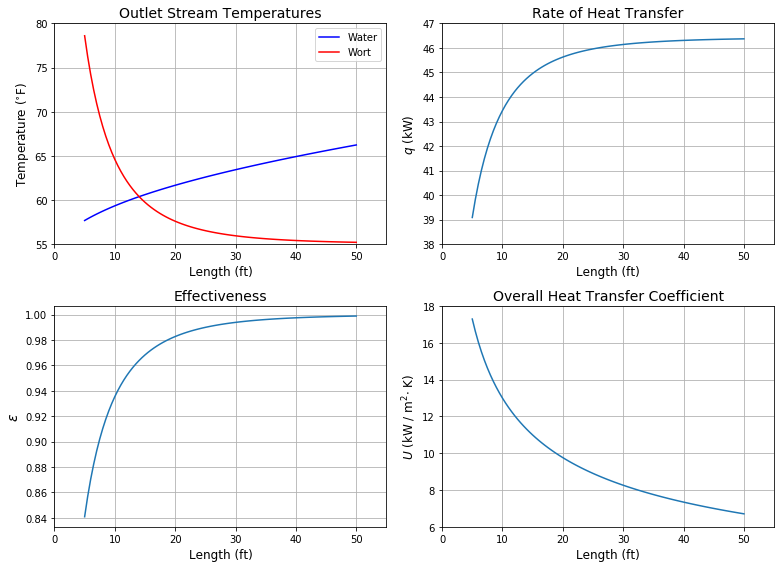

In [627]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (11,8))

ax1.plot(L_data,Tc_out_data,'b',label = 'Water')
ax1.plot(L_data,Th_out_data,'r',label = 'Wort')
ax1.set_xlim([0,55])
ax1.set_ylim([55,80])
ax1.set_title('Outlet Stream Temperatures',fontsize = 14)
ax1.set_xlabel('Length (ft)',fontsize = 12)
ax1.set_ylabel('Temperature ($^{\circ}$F)',fontsize = 12)
ax1.legend()
ax1.grid(True,which = 'both')

ax2.plot(L_data,q_data/1000)
ax2.set_xlim([0,55])
ax2.set_ylim([38,47])
ax2.set_xlabel('Length (ft)',fontsize = 12)
ax2.set_ylabel('$q$ (kW)',fontsize = 12)
ax2.set_title('Rate of Heat Transfer',fontsize = 14)
ax2.grid(True)

ax3.plot(L_data,E_data)
ax3.set_xlim([0,55])
ax3.set_xlabel('Length (ft)',fontsize = 12)
ax3.set_ylabel('$\epsilon$',fontsize = 14)
ax3.set_title('Effectiveness',fontsize = 14)
ax3.grid(True)

ax4.plot(L_data,U_data/1000)
ax4.set_xlim([0,55])
ax4.set_ylim([6,18])
ax4.set_xlabel('Length (ft)',fontsize = 12)
ax4.set_ylabel('$U$ (kW / m$^2$$\cdot$ K)',fontsize = 12)
ax4.set_title('Overall Heat Transfer Coefficient',fontsize = 14)
ax4.grid(True)

plt.tight_layout()
plt.show()

#fig.savefig('HX_data_1.png',dpi = 400)

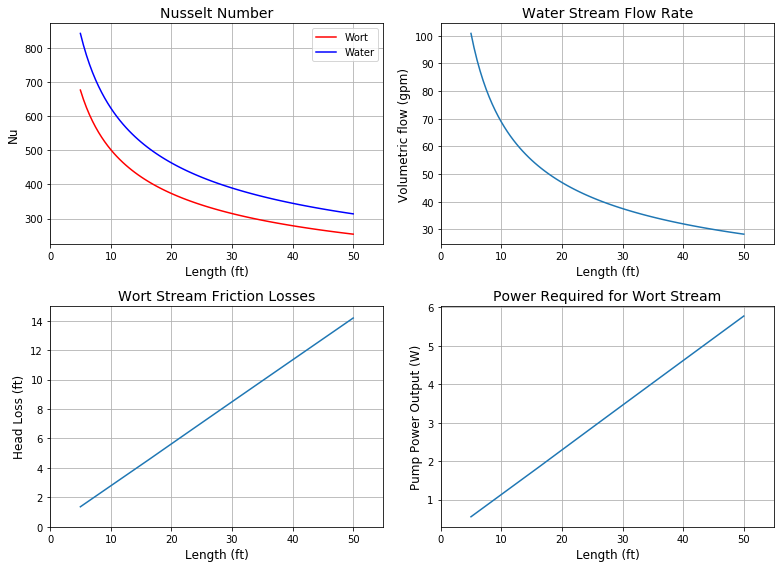

In [628]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (11,8))

ax1.plot(L_data,Nu_h_data,'r',label = 'Wort')
ax1.plot(L_data,Nu_c_data,'b',label = 'Water')
ax1.set_xlim([0,55])
ax1.set_xlabel('Length (ft)', fontsize = 12)
ax1.set_ylabel('Nu', fontsize = 12)
ax1.set_title('Nusselt Number', fontsize = 14)
ax1.legend()
ax1.grid(True)

ax2.plot(L_data,V_c_data)
ax2.set_xlim([0,55])
ax2.set_xlabel('Length (ft)',fontsize = 12)
ax2.set_ylabel('Volumetric flow (gpm)',fontsize = 12)
ax2.set_title('Water Stream Flow Rate',fontsize = 14)
ax2.grid(True)

ax3.plot(L_data,hL_data)
ax3.set_xlim([0,55])
ax3.set_ylim([0,15])
ax3.set_xlabel('Length (ft)',fontsize = 12)
ax3.set_ylabel('Head Loss (ft)',fontsize = 12)
ax3.set_title('Wort Stream Friction Losses',fontsize = 14)
ax3.grid(True)

ax4.plot(L_data,W_pump_data)
ax4.set_xlim([0,55])
ax4.set_xlabel('Length (ft)',fontsize = 12)
ax4.set_ylabel('Pump Power Output (W)',fontsize = 12)
ax4.set_title('Power Required for Wort Stream',fontsize = 14)
ax4.grid(True)

plt.tight_layout()
plt.show()

#fig.savefig('HX_data_2.png',dpi = 400)